In [5]:
from dataset_maker import load_dataset
from roi import setting_roi
from datetime import datetime
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Activation, MaxPooling2D, Conv2D, RNN, Reshape, concatenate, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint
import tensorflow_probability as tfp
import keras
import logging.config
import os
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tensorflow.keras.utils import plot_model

In [2]:
tfd = tfp.distributions
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

logging.config.fileConfig('logging.conf')
logger = logging.getLogger('tf2trainer')

logger.info(f'>> Python version     : {sys.version}')
logger.info(f'>> Tensorflow version : {tf.__version__}')
logger.info(f'>> Keras version      : {keras.__version__}')

classname = 'roadsurface'

2021-02-03 17:20:02 tf2trainer INFO >> Python version     : 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
2021-02-03 17:20:02 tf2trainer INFO >> Tensorflow version : 2.4.1
2021-02-03 17:20:02 tf2trainer INFO >> Keras version      : 2.4.3


In [3]:
FRAME_WIDTH, FRAME_HEIGHT = 1520, 2688
ROI_WIDTH, ROI_HEIGHT = 150, 150
ROI = []

In [3]:
# --------------------Change It-----------------------
SOURCE_PATH = r'F:\MK-SD53R\2021-01-28\202'  # Change directory
CATEGORIES = ['normal_day', 'snow']

SAMPLE_NUMBER = 10  # Less in Image Folder
EPOCHS = 10
BATCH_SIZE = 128

# 201 = Road, 202 = Weather
# 33A_201, 33A_201_old, 33A_201_fusion, 33C_201, 33C_201_fusion, 53R_201, 53R_202
ROI = [(1, 10), (2, 8), (2, 9), (2, 10), (3, 7), (3, 8), (3, 9), (4, 7), (4, 10), (4, 11), (5, 9), (5, 10), (5, 11), (6, 8), (6, 9), (6, 10)]
# ----------------------------------------------------

In [4]:
SOURCE_PATH = SOURCE_PATH.replace('\\', '/')
CLASSNUM = len(CATEGORIES)

In [7]:
CLASSNUM

2

In [8]:
(train_images, train_labels), (test_images, test_labels) = \
    load_dataset(source_path=SOURCE_PATH, roi=ROI, sample_number=SAMPLE_NUMBER, categories=CATEGORIES)

2021-02-03 17:20:05 dataset_maker INFO === Dataset Maker Start ===
2021-02-03 17:20:10 dataset_maker INFO Processing training dataset...
2021-02-03 17:20:12 dataset_maker INFO Processing test dataset...
2021-02-03 17:20:12 dataset_maker INFO Dataset Processing Finished.
2021-02-03 17:20:12 dataset_maker INFO train_image: (14, 320, 320, 3), train_label: (14,)
2021-02-03 17:20:12 dataset_maker INFO test_image: (6, 320, 320, 3), test_label: (6,)


In [11]:
train_images.shape

(14, 320, 320, 3)

In [10]:
# Preprocessing data
train_images = train_images / 255.
test_images = test_images / 255.

train_labels = keras.utils.to_categorical(train_labels, CLASSNUM)
test_labels = keras.utils.to_categorical(test_labels, CLASSNUM)

In [5]:
input_layer = Input(shape=(150, 150, 3))
x = Conv2D(32, kernel_size=(3, 3), padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

mix = concatenate([input_layer, x])

mp = MaxPooling2D(2)(mix)

x = Conv2D(128, kernel_size=(3, 3))(mp)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(256, kernel_size=(3, 3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

y = Conv2D(32, kernel_size=(3, 3))(mp)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(64, kernel_size=(3, 3))(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

mix2 = concatenate([x, y])

x = MaxPooling2D(2)(mix2)
x = Reshape(target_shape = (35*35, 320))(x)

x = LSTM(32, dropout=0.5, return_sequences = True)(x)
x = LSTM(64, dropout=0.5)(x)

x = Dense(512)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)
x = Dense(CLASSNUM)(x)
outputs = Activation('softmax')(x)

model = Model(inputs=input_layer, outputs = outputs)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 150, 150, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 150, 150, 32) 128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 150, 150, 32) 0           batch_normalization_6[0][0]      
______________________________________________________________________________________________

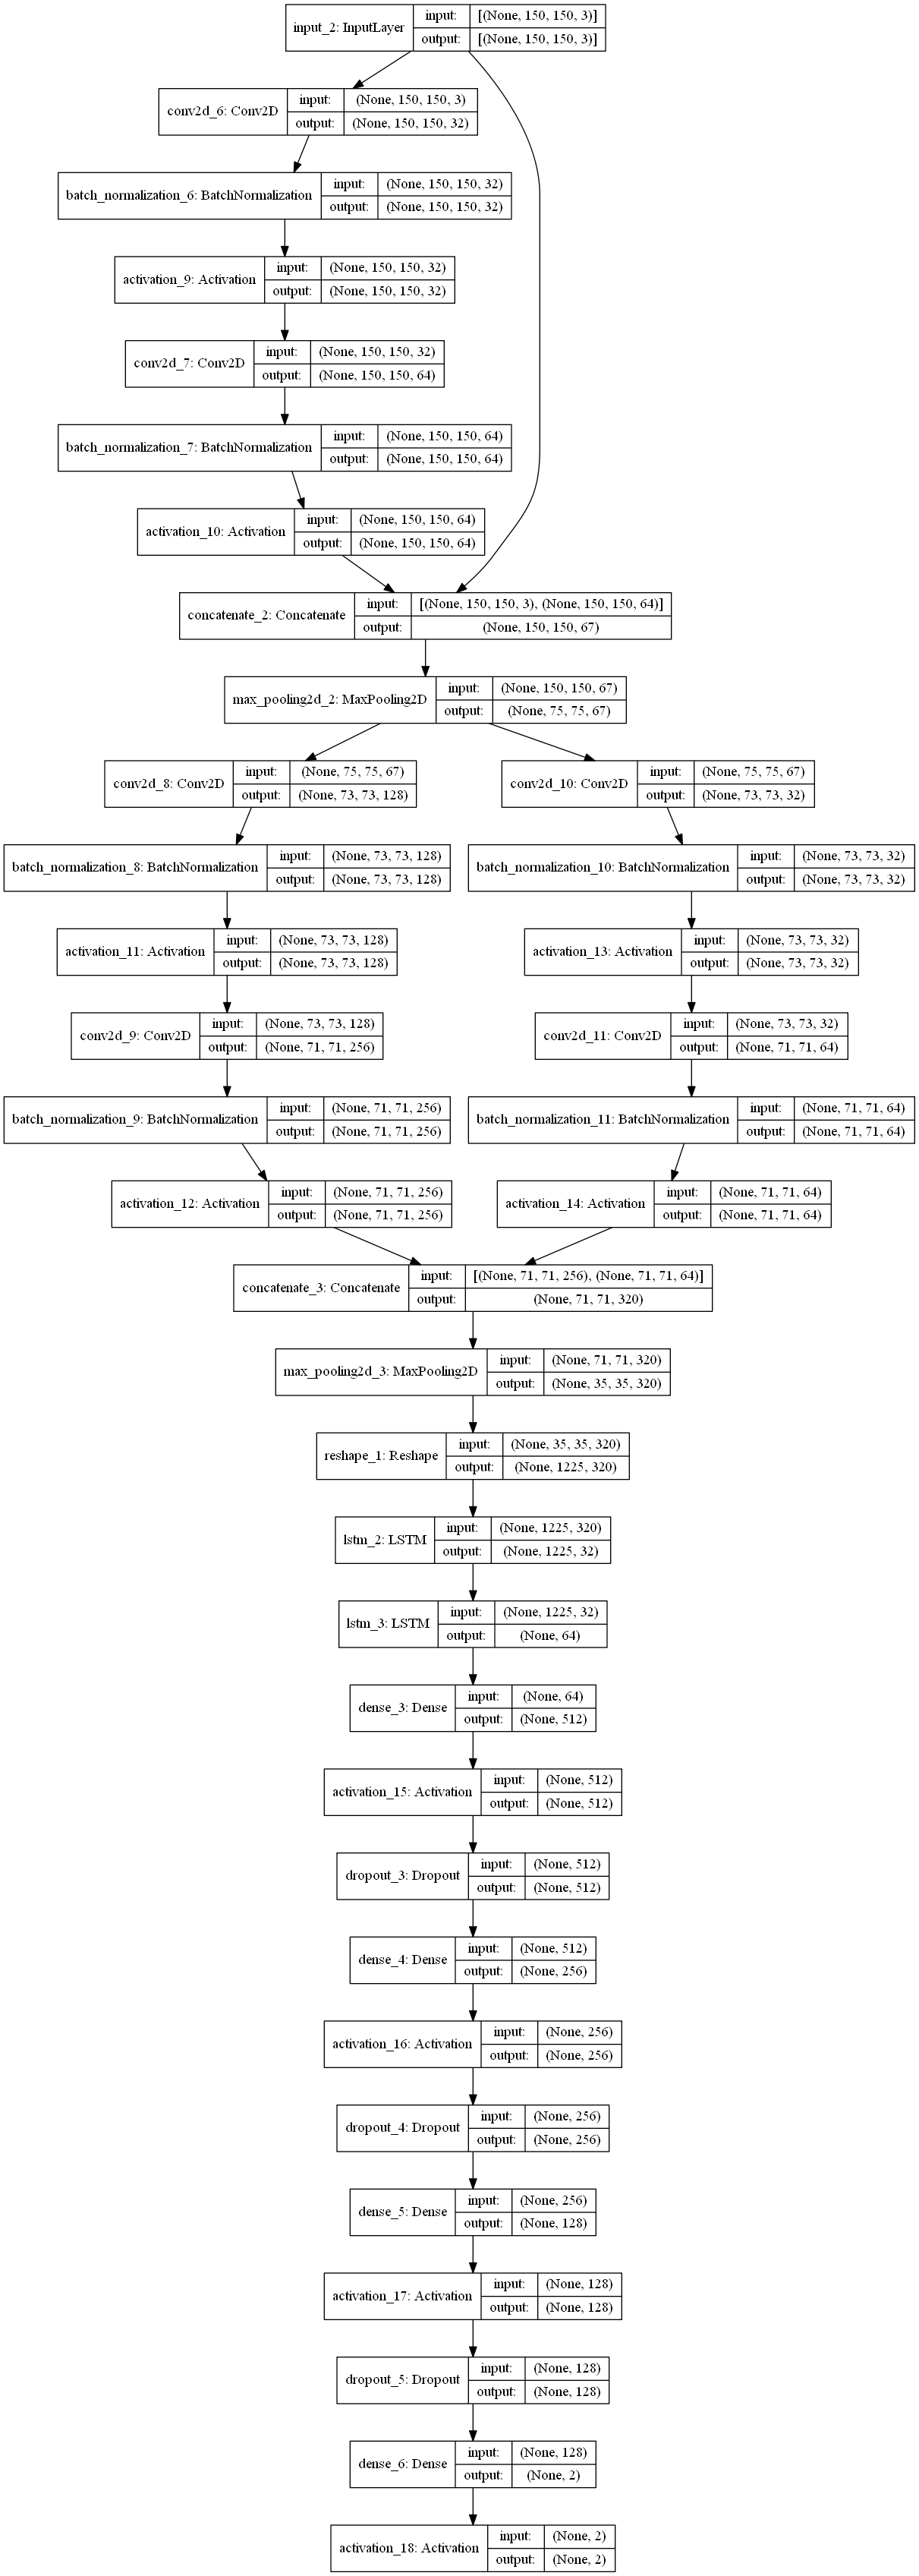

In [7]:
plot_model(model, show_shapes=True, to_file='model.png')

In [82]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [83]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1/1 [==============================] - 31s 31s/step - loss: 0.7008 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 24s 24s/step - loss: 0.6800 - accuracy: 0.4286 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 28s 28s/step - loss: 0.6706 - accuracy: 0.6429 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 28s 28s/step - loss: 0.6616 - accuracy: 0.7143 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 26s 26s/step - loss: 0.6948 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 26s 26s/step - loss: 0.6978 - accuracy: 0.6429 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 26s 26s/step - loss: 0.6967 - accuracy: 0.5714 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 8/10
1/1 [===========

In [43]:
input_layer_1 = Input(shape = (150, 150, 3))

x = Conv2D(32, activation='relu', kernel_size=(3, 3), kernel_initializer='he_normal')(input_layer_1)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, activation='relu', kernel_size=(3, 3))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)

input_layer_2 = Input(shape = (1, ), name = 'rgb_input')
y = Dense(512)(input_layer_2)
y = Dense(256)(y)
y = Dropout(0.3)(y)
y = Dense(128)(y)
y = Dropout(0.1)(y)
y = Dense(64)(y)

merged = concatenate([x, y])

x = Dense(256, activation='relu', kernel_initializer='he_normal')(merged)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.1)(x)
output = Dense(CLASSNUM, activation='softmax')(x)

model2 = Model(inputs = [input_layer_1, input_layer_2], outputs=output)

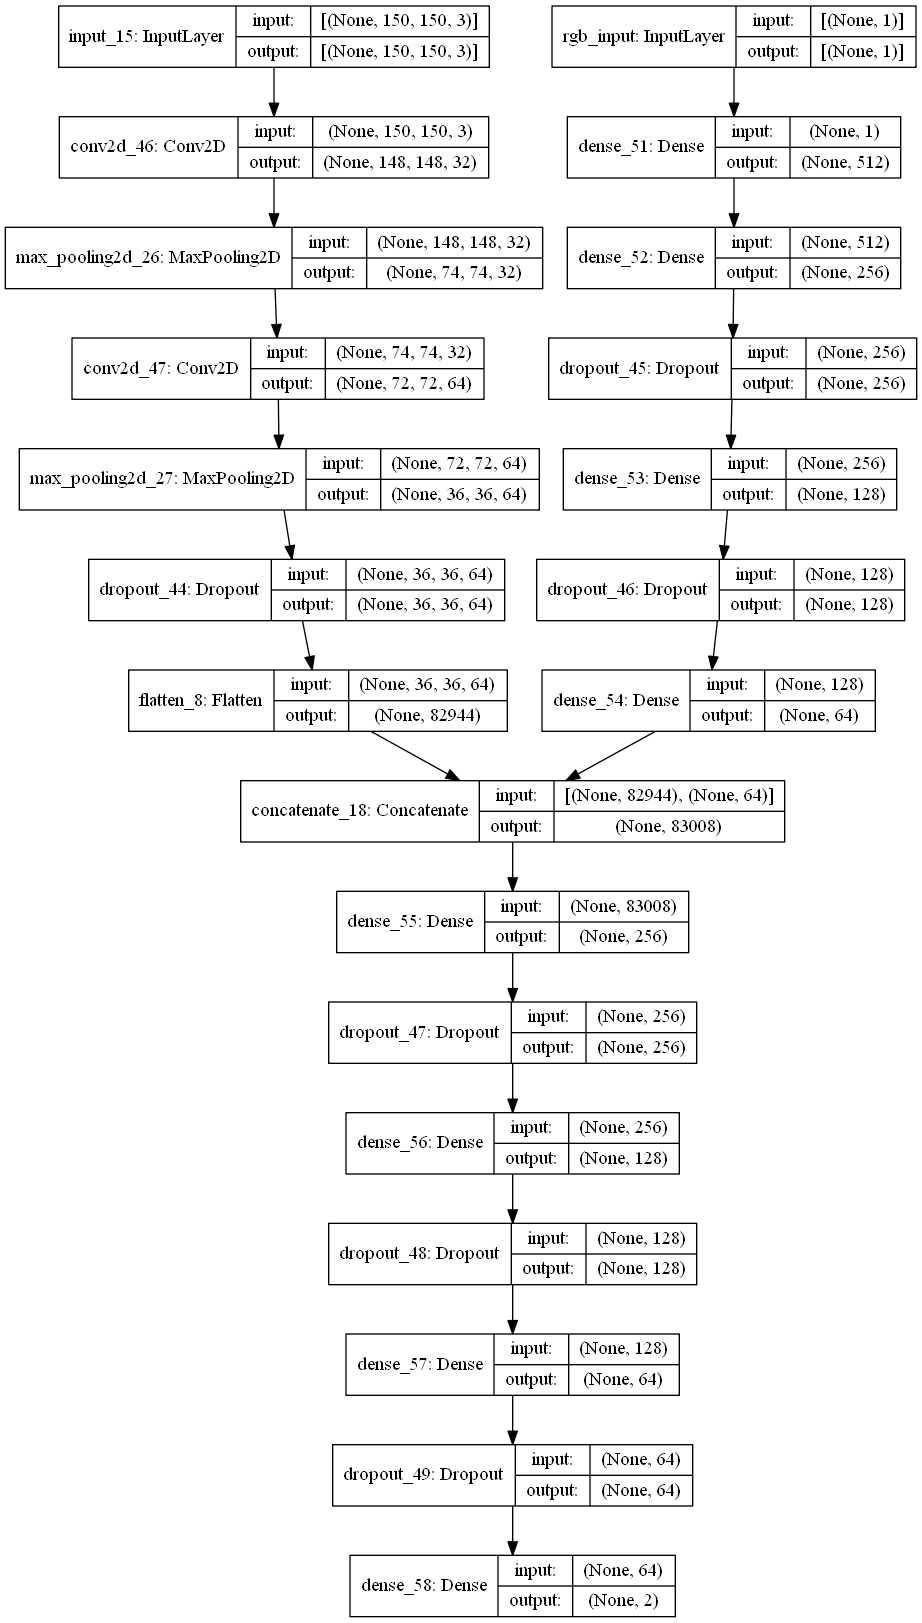

In [45]:
plot_model(model2, show_shapes=True, to_file='2input_models.png')

In [15]:
input_layer = Input(shape=(150, 150, 3))
x = Conv2D(32, kernel_size=(3, 3), padding='same', name='conv_1')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

mix = concatenate([input_layer, x])

mp = MaxPooling2D(2)(mix)

x = Conv2D(32, kernel_size=(3, 3), name='conv_3')(mp)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, kernel_size=(3, 3), name='conv_4')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = MaxPooling2D(2)(x)

x = Conv2D(128, kernel_size=(3, 3), name='conv_5')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(256, kernel_size=(3, 3), name='conv_6')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dropout(0.5)(x)


x = Dense(512)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(64)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(2)(x)
outputs = Activation('softmax')(x)

model = Model(inputs=input_layer, outputs=outputs)

In [12]:
input_layer = Input(shape=(150, 150, 3))
x = Conv2D(32, kernel_size=(3, 3), padding='same', name='conv_1')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

mix = concatenate([input_layer, x])

mp = MaxPooling2D(2)(mix)

x = Conv2D(32, kernel_size=(3, 3), name='conv_3')(mp)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, kernel_size=(3, 3), name='conv_4')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

y = Conv2D(32, kernel_size=(3, 3), name='conv_5')(mp)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(64, kernel_size=(3, 3), name='conv_6')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)


x = MaxPooling2D(2)(x)
y = MaxPooling2D(2)(y)
mix2 = concatenate([x, y])

x = MaxPooling2D(2)(mix2)

x = Flatten()(x)
x = Dropout(0.5)(x)

x = Dense(512)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(64)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(2)(x)
outputs = Activation('softmax')(x)

model = Model(inputs=input_layer, outputs=outputs)

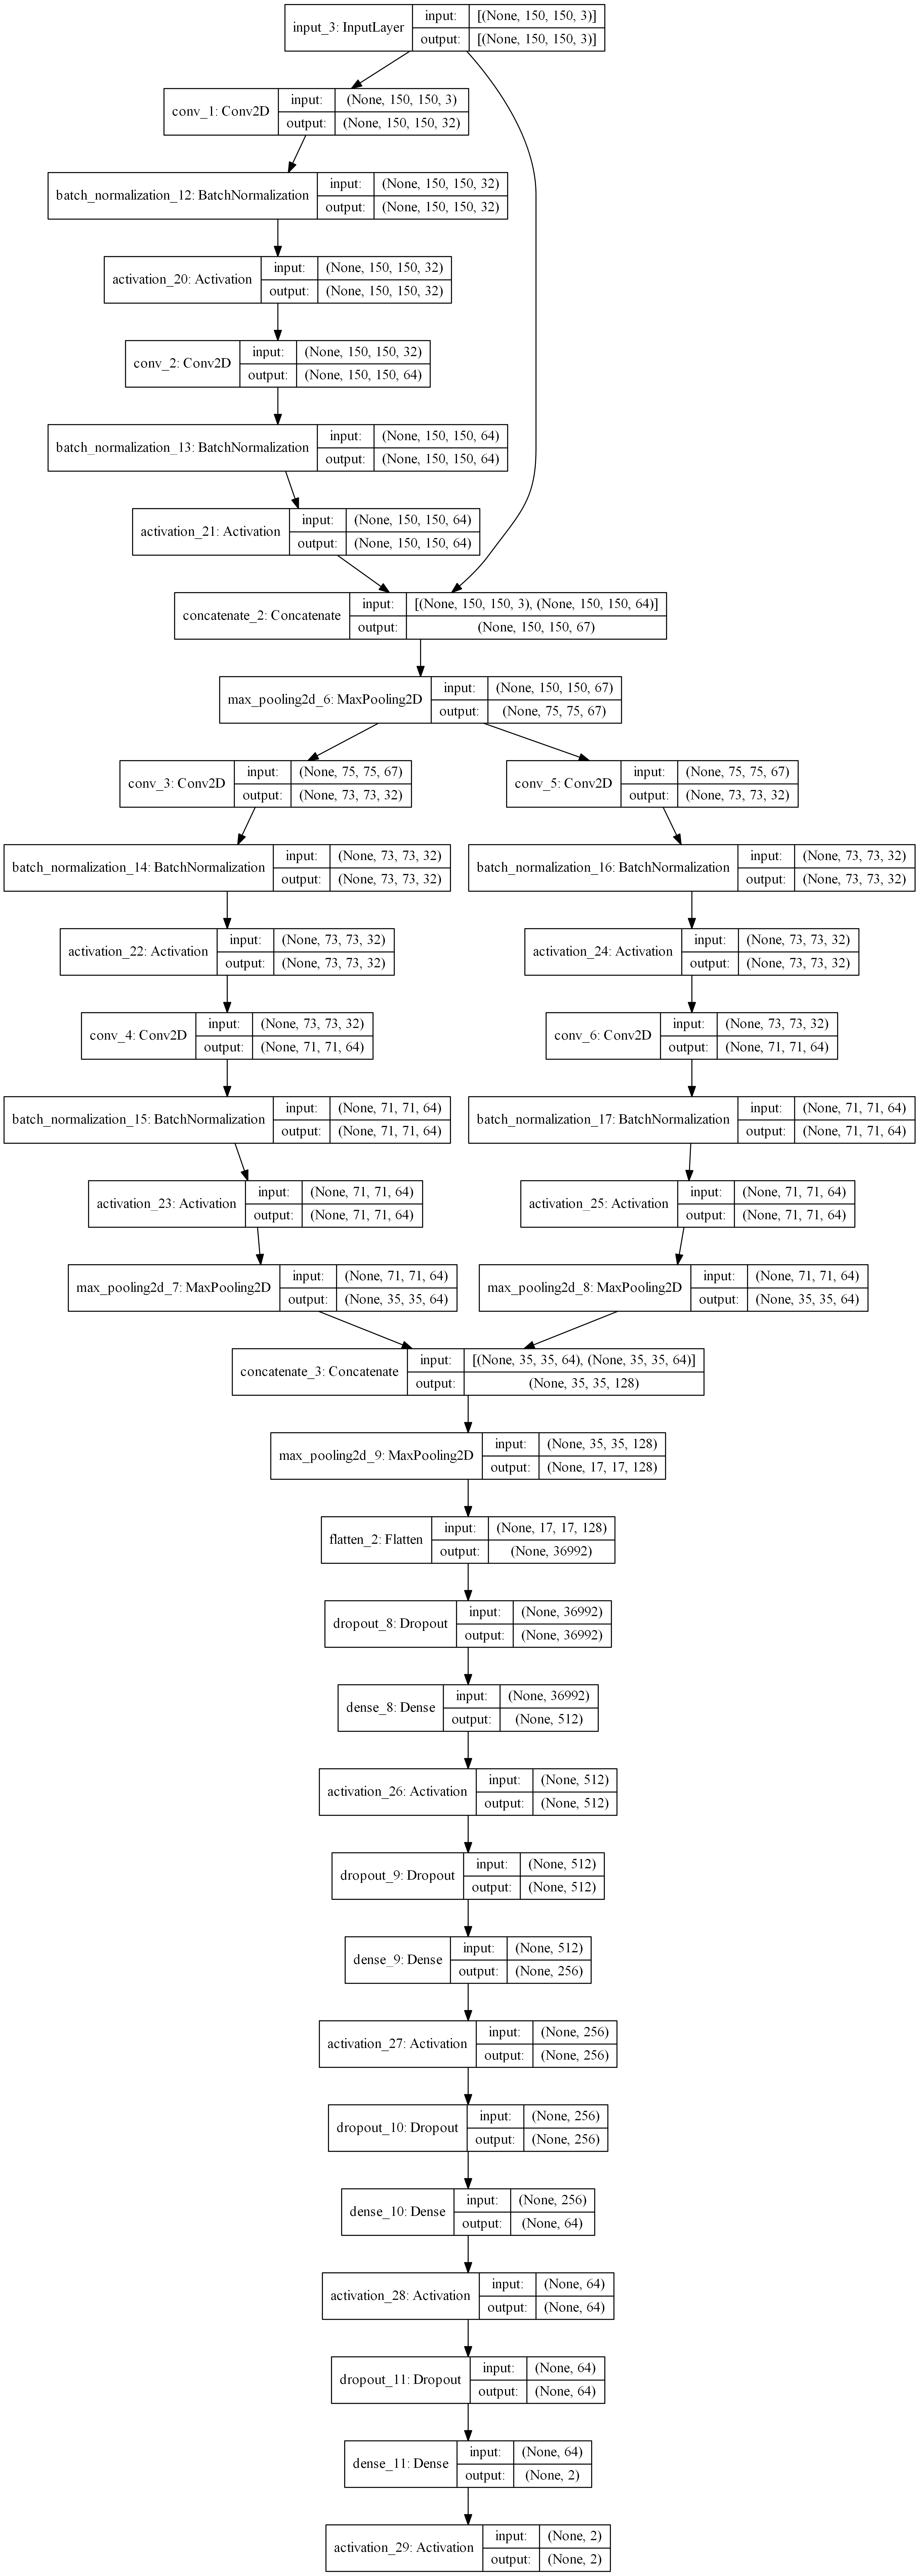

In [13]:
plot_model(model, show_shapes=True, expand_nested=True, dpi=256)

In [14]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 150, 150, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 150, 150, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 150, 150, 32) 0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

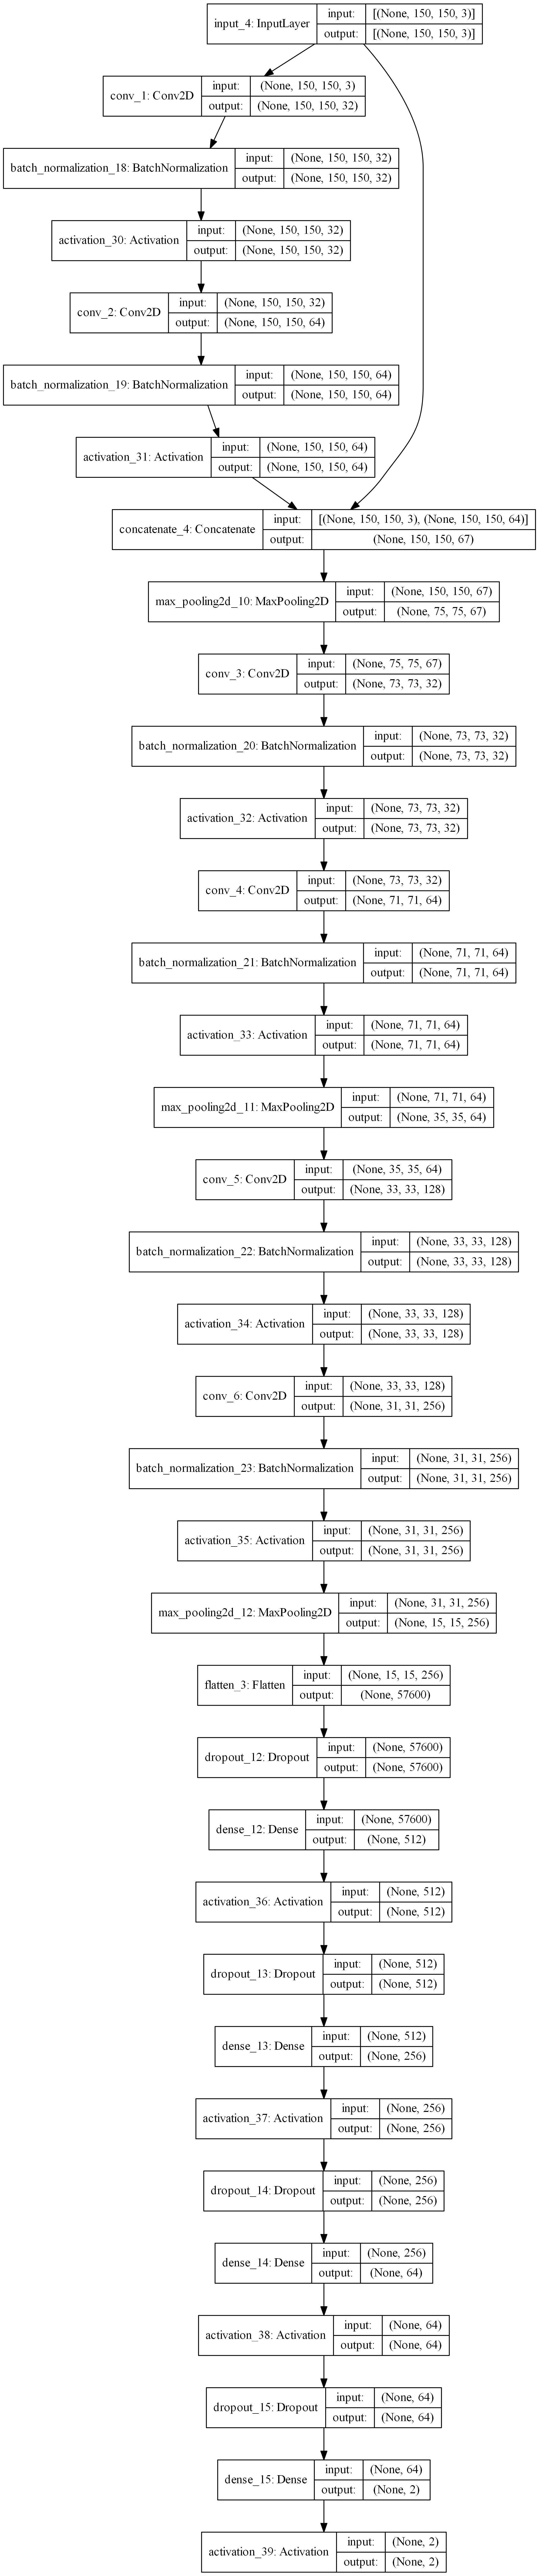

In [16]:
plot_model(model, show_shapes=True, expand_nested=True, dpi=256)

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 150, 150, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 150, 150, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 150, 150, 32) 0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

In [26]:
input_layer = Input(shape=self.train_images[0].shape)
x = Conv2D(32, kernel_size=(3, 3), padding='same', name='conv_1')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

mix = concatenate([input_layer, x])

mp = MaxPooling2D(2)(mix)

x = Conv2D(32, kernel_size=(3, 3), name='conv_3')(mp)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, kernel_size=(3, 3), name='conv_4')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

y = Conv2D(32, kernel_size=(3, 3), name='conv_5')(mp)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(64, kernel_size=(3, 3), name='conv_6')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)


x = MaxPooling2D(2)(x)
y = MaxPooling2D(2)(y)
mix2 = concatenate([x, y])

x = MaxPooling2D(2)(mix2)

x = Reshape([17*17, 128])(x)
x = Dropout(0.5)(x)

x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
x = Bidirectional(LSTM(32, dropout=0.3))(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(64)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)
x = Dense(self.CLASSNUM)(x)
outputs = Activation('softmax')(x)

model = Model(inputs=input_layer, outputs=outputs)

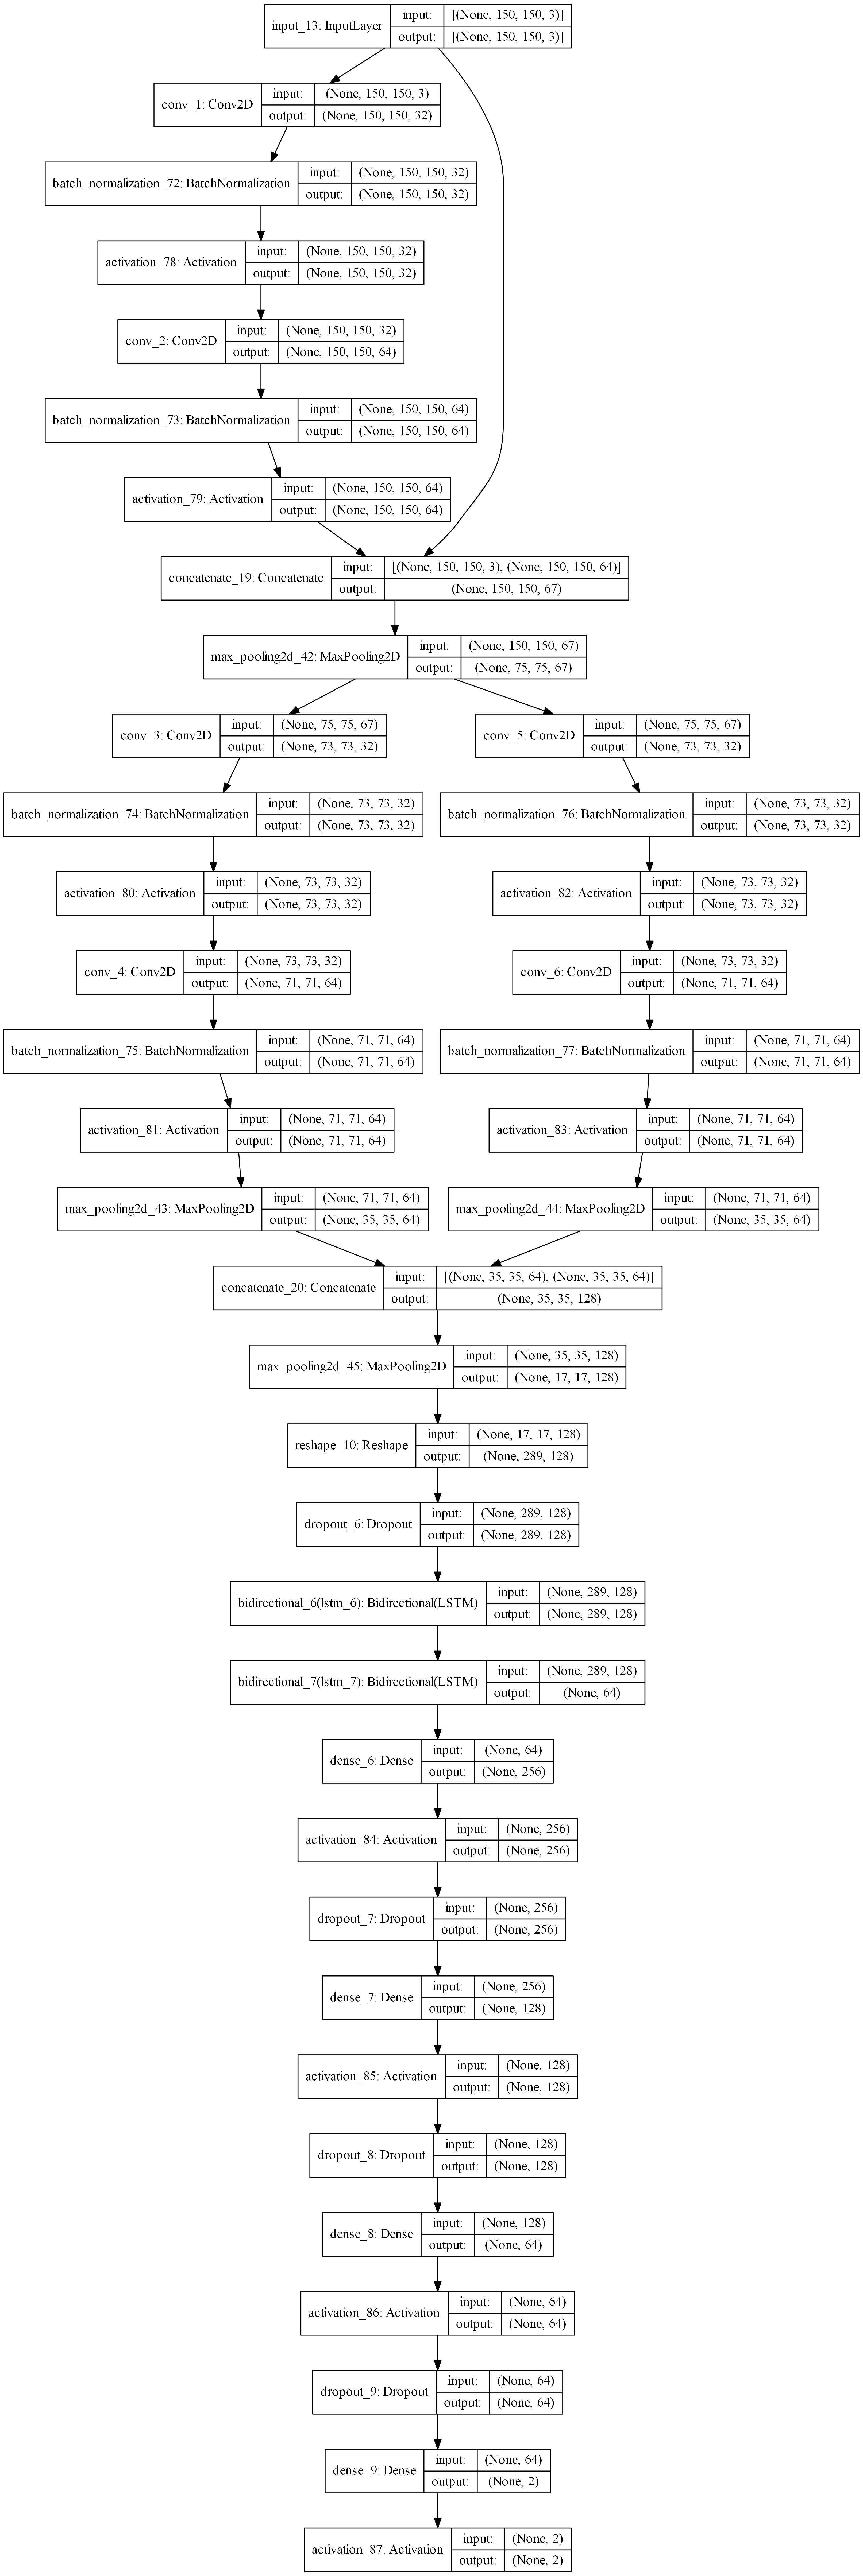

In [27]:
plot_model(model, show_shapes=True, expand_nested=True, dpi=256)